In [1]:
import os
import csv
from collections import Counter

os.getcwd()

'/home/maxjo/Projects/Bamboo_kaggle'

In [2]:
with open('./datasets/train.csv', encoding='utf-8') as f:
    csv_reader = csv.DictReader(f)
    train_data = list(csv_reader)

train_data_fname, train_data_label = zip(*( (d['filename'], d['label']) for d in train_data ))

with open('./datasets/test.csv', encoding='utf-8') as f:
    csv_reader = csv.DictReader(f)
    test_data = list(csv_reader)

test_data_fname = [d['filename'] for d in test_data]

In [3]:
len(train_data_fname), len(test_data_fname)

(5199, 1300)

In [4]:
list(zip(train_data_fname, train_data_label))[:10]

[('image_0001.jpg', 'MANGROVE SKIPPER'),
 ('image_0002.jpg', 'GREAT JAY'),
 ('image_0003.jpg', 'SLEEPY ORANGE'),
 ('image_0004.jpg', 'CLEOPATRA'),
 ('image_0005.jpg', 'PAINTED LADY'),
 ('image_0006.jpg', 'EASTERN PINE ELFIN'),
 ('image_0007.jpg', 'TROPICAL LEAFWING'),
 ('image_0008.jpg', 'EASTERN COMA'),
 ('image_0009.jpg', 'CHECQUERED SKIPPER'),
 ('image_0010.jpg', 'VICEROY')]

In [5]:
butterfly_counts = Counter(train_data_label)

print(len(butterfly_counts))
print(butterfly_counts.most_common(10))

75
[('MOURNING CLOAK', 105), ('SLEEPY ORANGE', 85), ('ATALA', 80), ('BROWN SIPROETA', 79), ('MILBERTS TORTOISESHELL', 77), ('CRECENT', 77), ('ORANGE TIP', 77), ('BANDED ORANGE HELICONIAN', 77), ('SCARCE SWALLOW', 77), ('RED CRACKER', 77)]


---

### Saving datasets

In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

butterfly_names = sorted(set(train_data_label))

label_to_index = {name: i for i, name in enumerate(butterfly_names)}
index_to_label = {i: name for i, name in enumerate(butterfly_names)}

data_label_index = [label_to_index[label] for label in train_data_label]

print(len(label_to_index), len(index_to_label))
data_label_index[:10]

2025-07-03 02:35:58.572933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751477758.640587  545553 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751477758.661401  545553 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751477758.809954  545553 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751477758.810021  545553 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751477758.810023  545553 computation_placer.cc:177] computation placer alr

75 75


[40, 32, 64, 17, 49, 28, 68, 26, 15, 71]

In [7]:
for labels in butterfly_names:
    os.makedirs(f'./datasets/classified/{labels}', exist_ok=True)

In [8]:
import shutil
from tqdm import tqdm

for fname, label in tqdm(list(zip(train_data_fname, train_data_label))):
    shutil.copy(f'./datasets/train/{fname}', f'./datasets/classified/{label}/{fname}')

100%|██████████| 5199/5199 [00:03<00:00, 1459.99it/s]


In [9]:
import splitfolders

try:
    os.mkdir('./datasets/classified_split', )
except FileExistsError:
    print('dir already exists')

splitfolders.ratio("./datasets/classified", output="./datasets/classified_split",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

dir already exists


Copying files: 5199 files [00:01, 2702.30 files/s]


### saving `class_weights` (imbalance)

In [10]:
[print(f'count: {c} ->\tid: {label_to_index[l]}\t- {l}') for l, c in butterfly_counts.most_common(75)]
print()

count: 105 ->	id: 45	- MOURNING CLOAK
count: 85 ->	id: 64	- SLEEPY ORANGE
count: 80 ->	id: 5	- ATALA
count: 79 ->	id: 12	- BROWN SIPROETA
count: 77 ->	id: 43	- MILBERTS TORTOISESHELL
count: 77 ->	id: 23	- CRECENT
count: 77 ->	id: 47	- ORANGE TIP
count: 77 ->	id: 6	- BANDED ORANGE HELICONIAN
count: 77 ->	id: 62	- SCARCE SWALLOW
count: 77 ->	id: 59	- RED CRACKER
count: 76 ->	id: 28	- EASTERN PINE ELFIN
count: 76 ->	id: 15	- CHECQUERED SKIPPER
count: 76 ->	id: 36	- IPHICLUS SISTER
count: 75 ->	id: 32	- GREAT JAY
count: 75 ->	id: 25	- DANAID EGGFLY
count: 75 ->	id: 22	- COPPER TAIL
count: 74 ->	id: 17	- CLEOPATRA
count: 74 ->	id: 26	- EASTERN COMA
count: 74 ->	id: 56	- PURPLISH COPPER
count: 74 ->	id: 27	- EASTERN DAPPLE WHITE
count: 74 ->	id: 19	- CLOUDED SULPHUR
count: 72 ->	id: 50	- PAPER KITE
count: 72 ->	id: 4	- APPOLLO
count: 72 ->	id: 13	- CABBAGE WHITE
count: 72 ->	id: 65	- SOOTYWING
count: 72 ->	id: 21	- COMMON WOOD-NYMPH
count: 72 ->	id: 44	- MONARCH
count: 71 ->	id: 60	- RED POS

In [11]:
from sklearn.utils import class_weight
import numpy as np
import pickle

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array(list(index_to_label.keys())),
    y=np.array(data_label_index)
)

# least common and most common class weights
class_weights[45], class_weights[72]

(np.float64(0.6601904761904762), np.float64(1.216140350877193))

In [12]:
with open('./datasets/class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights, f)

---

In [13]:
butterfly_test = image_dataset_from_directory(
    './datasets/classified_split/test',
    # Labels should be sorted according to the alphanumeric order of the image file paths 
    # (obtained via os.walk(directory) in Python).
    labels='inferred',
    image_size=(224, 224),
    color_mode='rgb',  # 3 dim
    batch_size=32,
    shuffle=True,
    seed=42,
)
butterfly_train = image_dataset_from_directory(
    './datasets/classified_split/train',
    # Labels should be sorted according to the alphanumeric order of the image file paths 
    # (obtained via os.walk(directory) in Python).
    labels='inferred',
    image_size=(224, 224),
    color_mode='rgb',  # 3 dim
    batch_size=32,
    shuffle=True,
    seed=42,
)
butterfly_val = image_dataset_from_directory(
    './datasets/classified_split/val',
    # Labels should be sorted according to the alphanumeric order of the image file paths 
    # (obtained via os.walk(directory) in Python).
    labels='inferred',
    image_size=(224, 224),
    color_mode='rgb',  # 3 dim
    batch_size=32,
    shuffle=True,
    seed=42,
)

dataset_path = './datasets/'
butterfly_test.save(os.path.join(dataset_path, 'butterfly_test')); print('butterfly_test saved')
butterfly_train.save(os.path.join(dataset_path, 'butterfly_train')); print('butterfly_train saved')
butterfly_val.save(os.path.join(dataset_path, 'butterfly_val')); print('butterfly_val saved')

Found 582 files belonging to 75 classes.


I0000 00:00:1751477769.760994  545553 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:2b:00.0, compute capability: 8.9


Found 4131 files belonging to 75 classes.
Found 486 files belonging to 75 classes.
butterfly_test saved
butterfly_train saved
butterfly_val saved


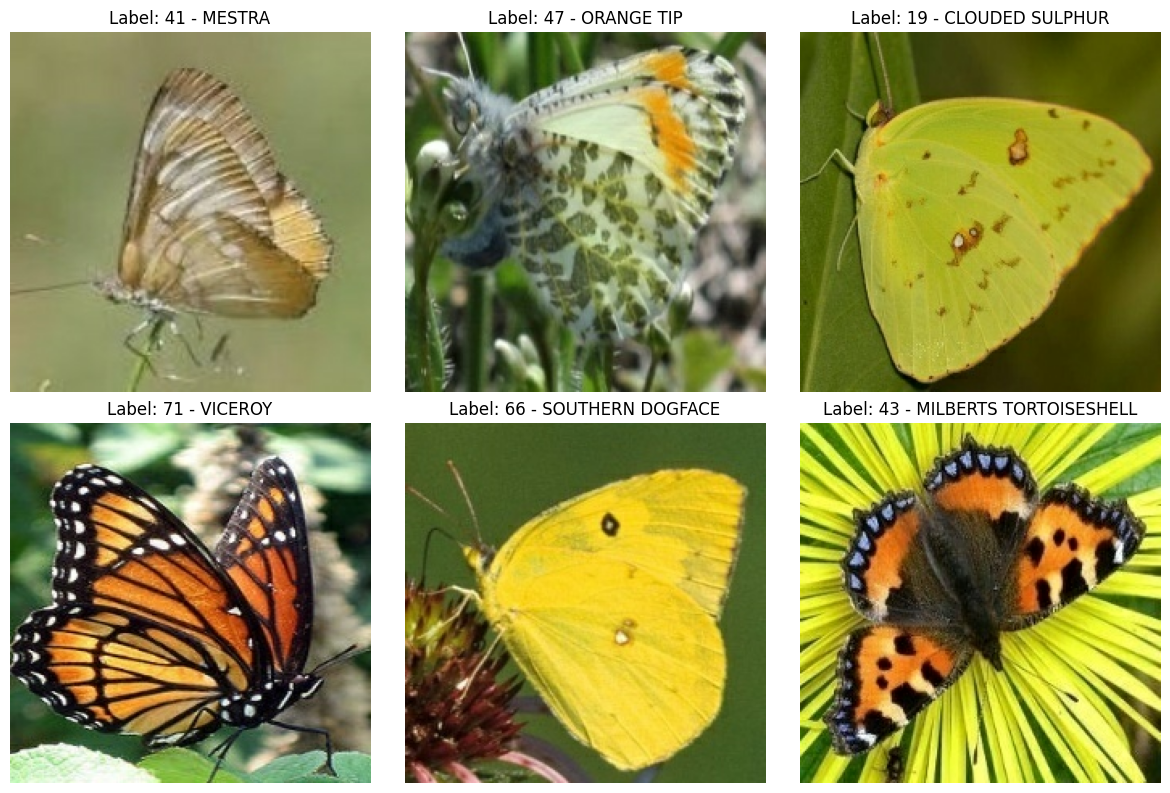

In [19]:
import matplotlib.pyplot as plt
import numpy as np

batch_images, batch_labels = np.array([]), np.array([])

for images, labels in butterfly_train.take(1):  # take(1) as in a single batch (32 images), single loop!
    batch_images = images
    batch_labels = labels

plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(batch_images[i].numpy().astype("uint8"))
    plt.title(f"Label: {batch_labels[i].numpy()} - {index_to_label[batch_labels[i].numpy()]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


**Note: `index_to_label` & `label_to_index` and `image_dataset_from_directory` all labels to integer in alphabetical order! Hence the compatibility**

In [20]:
for idx, img in enumerate(batch_images[:10]):
    print(f"Image {idx} shape: {img.shape}")

Image 0 shape: (224, 224, 3)
Image 1 shape: (224, 224, 3)
Image 2 shape: (224, 224, 3)
Image 3 shape: (224, 224, 3)
Image 4 shape: (224, 224, 3)
Image 5 shape: (224, 224, 3)
Image 6 shape: (224, 224, 3)
Image 7 shape: (224, 224, 3)
Image 8 shape: (224, 224, 3)
Image 9 shape: (224, 224, 3)


---

### Notes
- 75 classes
- not a big amount of class imbalance (min to max ratio of 1:2, mostly 60 ~ 70)
- (good) images are mostly centered
- (NG) different BG, low res, watermarks

### Candidate models
- EfficientNet-V2 (CNN)
- Inception-V3 (CNN)
- Vision Transformers (ViT)
- Ensemble (CNN + ViT)

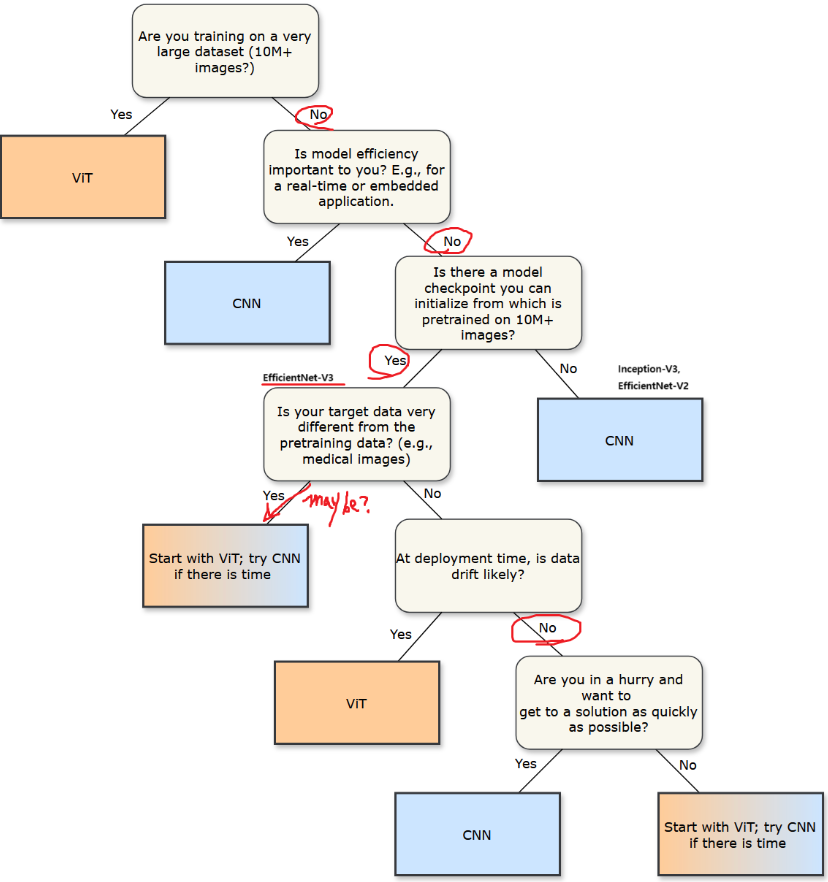

- https://tobiasvanderwerff.com/2024/05/15/cnn-vs-vit.html

- https://www.tensorflow.org/guide/keras/transfer_learning